# Laboratorium 4 - rekomendacje dla portali informacyjnych

## Przygotowanie

 * pobierz i wypakuj dataset: https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip
   * więcej możesz poczytać tutaj: https://learn.microsoft.com/en-us/azure/open-datasets/dataset-microsoft-news
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab4`
 * zainstaluj potrzebne biblioteki:
 `pip install nltk sklearn`

## Część 1. - przygotowanie danych

In [1]:
# importujemy wszystkie potrzebne pakiety

import codecs
from collections import defaultdict # mozesz uzyc zamiast zwyklego slownika, rozwaz wplyw na czas obliczen
import math
import re
from string import punctuation

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

# mozesz uzyc do obliczania najbardziej podobnych tekstow zamiast liczenia "na piechote"
# ale pamietaj o dostosowaniu formatu danych
from sklearn.neighbors import NearestNeighbors

# na potrzeby wizualizacji
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\panja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\panja\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\panja\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


In [2]:
# definiujemy potrzebne zmienne

PATH = './MINDsmall_train'
STOPWORDS = set(stopwords.words('english'))

In [3]:
# wczytujemy metadane artykulow

def parse_news_entry(entry):
    news_id, category, subcategory, title, abstract = entry.split('\t')[:5]
    return {
        'news_id': news_id,
        'category': category,
        'subcategory': subcategory,
        'title': title,
        'abstract': abstract
    }

def get_news_metadata():
    with codecs.open(f'{PATH}/news.tsv', 'r', 'UTF-8') as f:
        raw = [x for x in f.read().split('\n') if x]
        parsed_entries = [parse_news_entry(entry) for entry in raw]
        return {x['news_id']: x for x in parsed_entries}

news = get_news_metadata()
news_ids = sorted(list(news.keys()))
news_indices = {x[1]: x[0] for x in enumerate(news_ids)}
print(len(news))

51282


In [4]:
def parse_history_entry(entry):
    _id, user_id, _time, history, _impressions = entry.split('\t')
    history = [x for x in history.split() if x]
    return user_id, history

def get_users_history():
    with codecs.open(f'{PATH}/behaviors.tsv', 'r', 'UTF-8') as f:
        lines = [x for x in f.read().split('\n') if x]
        entries = [parse_history_entry(x) for x in lines]
        return dict(entries)

users_history = get_users_history()
test_users = 'U53231', 'U89744', 'U10045', 'U92486', 'U70879'
print(len(users_history))

50000


## Część 2. - TF-IDF

In [5]:
# normalizujemy teksty na potrzeby dalszego przetwarzania
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer

def preprocess_text(text):
    # zamieniamy wszystkie ciagi bialych znakow na pojedyncze spacje
    text = re.sub(r'\s+', ' ', text)
    # usuwamy znaki interpunkcyjne
    text = text.translate(str.maketrans('', '', string.punctuation))
    # usuwamy wszystkie liczby
    text = re.sub(r'\d+', '', text)
    # podmieniamy wszystkie wielkie litery
    text = text.lower()
    # dzielimy na tokeny
    tokens = word_tokenize(text)
    # usuwamy stopwords
    tokens = [word for word in tokens if word not in STOPWORDS]

    return tokens

def stem_texts(corpus, stemmer_type="porter"):
    if stemmer_type == "porter":
        stemmer = PorterStemmer()
    elif stemmer_type == "snowball":
        stemmer = SnowballStemmer("english")
    else:
        raise ValueError("stemmer_type must be 'porter' or 'snowball'")
    return [[stemmer.stem(word) for word in preprocess_text(text)] for text in corpus]

texts = [news[news_id]['abstract'] for news_id in news_ids]
stemmed_texts_porter = stem_texts(texts, "porter")
stemmed_texts_snowball = stem_texts(texts, "snowball")

In [6]:
# porownajmy teksty przed i po przetworzeniu

print(texts[2] + '\n')
print(' '.join(stemmed_texts_porter[2]))
print(' '.join(stemmed_texts_snowball[2]))

"I think we have a really good team, and a team that can really do some special, good things because that group is very close in there." - Brian Schmetzer

think realli good team team realli special good thing group close brian schmetzer
think realli good team team realli special good thing group close brian schmetzer


In [7]:
# tworzymy liste wszystkich slow w korpusie

def get_all_words_sorted(corpus):
    # generujemy posortowana alfabetycznie liste wszystkich slow (tokenow)
    res = set()
    for tokens in corpus:
        for token in tokens:
            res.add(token)

    return sorted(res)

wordlist = get_all_words_sorted(stemmed_texts_porter)
word_indices = {x[1]: x[0] for x in enumerate(wordlist)}
print(len(wordlist))

wordlist = get_all_words_sorted(stemmed_texts_snowball)
word_indices = {x[1]: x[0] for x in enumerate(wordlist)}
print(len(wordlist))

41881
41846


In [9]:
# obliczamy liczbe tekstow, w ktorych wystapilo kazde ze slow
# pamietaj, ze jesli slowo wystapilo w danym tekscie wielokrotnie, to liczymy je tylko raz

def get_document_frequencies(corpus, wordlist):
    # return {word -> count}
    vocab = set(wordlist)
    df = {w: 0 for w in wordlist}

    for tokens in corpus:
        for w in (set(tokens) & vocab):
            df[w] += 1

    return df

document_frequency = get_document_frequencies(stemmed_texts_porter, wordlist)
print(document_frequency)

{'aa': 8, 'aaa': 21, 'aaaa': 1, 'aaaaaaaand': 1, 'aaaaaand': 1, 'aaaaah': 1, 'aac': 8, 'aaf': 2, 'aagdzga': 1, 'aah': 2, 'aalia': 2, 'aaliyah': 2, 'aamir': 1, 'aanchal': 1, 'aannounc': 1, 'aap': 2, 'aapl': 1, 'aarni': 1, 'aarnseth': 1, 'aaron': 129, 'aarp': 3, 'aau': 3, 'ab': 19, 'aba': 2, 'ababi': 1, 'ababneh': 1, 'aback': 3, 'abadi': 1, 'abajustin': 1, 'abalon': 2, 'abandon': 95, 'abar': 1, 'abat': 2, 'abba': 1, 'abbasov': 1, 'abbevill': 0, 'abbey': 4, 'abbi': 7, 'abbott': 18, 'abc': 90, 'abcth': 1, 'abcv': 1, 'abdelaziz': 1, 'abdelkad': 4, 'abdi': 3, 'abdic': 1, 'abdihakim': 2, 'abdomen': 7, 'abdomin': 8, 'abduct': 25, 'abdul': 2, 'abduljabbar': 1, 'abdullah': 3, 'abdulmateen': 1, 'abdulwahe': 1, 'abdurrahman': 1, 'abe': 7, 'abel': 2, 'abellard': 5, 'abelseth': 2, 'abercrombi': 1, 'aberdeen': 4, 'abhijit': 2, 'abhorr': 1, 'abid': 3, 'abigail': 10, 'abil': 90, 'abimelec': 1, 'abington': 2, 'abita': 1, 'abject': 1, 'abkhazia': 1, 'abl': 339, 'ablaz': 6, 'ablebodi': 1, 'abloh': 1, 'abl

In [10]:
# obliczamy liczbe wystapien kazdego slowa w kazdym tekscie

def get_term_frequencies(corpus, news_indices):
    # return {news_id -> {word -> count}}
    idx_to_id = {idx: news_id for news_id, idx in news_indices.items()}
    res = {}

    for i, tokens in enumerate(corpus):
        news_id = idx_to_id.get(i)
        counts = {}
        for w in tokens:
            counts[w] = counts.get(w, 0) + 1
        res[news_id] = counts

    return res

term_frequency = get_term_frequencies(stemmed_texts_porter, news_indices)

In [11]:
# sprawdzmy wyniki

term_frequency[news_ids[2]]

{'think': 1,
 'realli': 2,
 'good': 2,
 'team': 2,
 'special': 1,
 'thing': 1,
 'group': 1,
 'close': 1,
 'brian': 1,
 'schmetzer': 1}

In [12]:
# obliczamy metryke tf_idf

def calculate_tf_idf(term_frequency, document_frequency, corpus_size):
    # return {news_id -> {word -> tf_idf}}
    res = {}

    for news_id, counts in term_frequency.items():
        vec = {}
        for w, c in counts.items():
            df = document_frequency.get(w, 0)
            if df <= 0:
                continue
            tf = c
            idf = math.log(corpus_size / df)
            vec[w] = tf * idf
        res[news_id] = vec

    return res

tf_idf = calculate_tf_idf(term_frequency, document_frequency, len(news_ids))

In [13]:
# sprawdzmy wyniki

tf_idf[news_ids[2]]

{'think': 4.360459856758821,
 'realli': 9.707261090572182,
 'good': 8.085400658139525,
 'team': 6.157356388748834,
 'special': 4.765161897298483,
 'thing': 4.111693200556713,
 'group': 4.261685870235309,
 'close': 3.9244235881453897,
 'brian': 5.624739267315748,
 'schmetzer': 9.458800731274183}

## Część 3. - Podobieństwo tekstów

In [14]:
# obliczmy odleglosc miedzy dwoma artykulami
# przetestuj rozne metryki odleglosci i wybierz najlepsza

def calculate_distance(tf_idf, id1, id2, metric = "cosine"):
    v1 = tf_idf.get(id1, {}) or {}
    v2 = tf_idf.get(id2, {}) or {}

    # 1 - ((∑_i a_i * b_i) / ( sqrt(∑_i a_i^2) * sqrt(∑_i b_i^2) ))
    def cosine_distance(a, b):
        dot = sum(a[w] * b.get(w, 0) for w in a)
        n1 = math.sqrt(sum(x * x for x in a.values()))
        n2 = math.sqrt(sum(x * x for x in b.values()))
        if n1 == 0 or n2 == 0:
            return 1
        cos_sim = dot / (n1 * n2)
        return 1 - cos_sim

    # sqrt( ∑_i (a_i - b_i)^2 )
    def euclidean_distance(a, b):
        keys = set(a) | set(b)
        return math.sqrt(sum((a.get(k, 0) - b.get(k, 0))**2 for k in keys))

    # ∑_i |a_i - b_i|
    def manhattan(a, b):
        keys = set(a) | set(b)
        return sum(abs(a.get(k,0) - b.get(k,0)) for k in keys)

    if metric == "euclidean":
        return euclidean_distance(v1, v2)
    elif metric == "manhattan":
        return manhattan(v1, v2)
    else:
        return cosine_distance(v1, v2)

print(calculate_distance(tf_idf, news_ids[2], news_ids[1]))
print(calculate_distance(tf_idf, news_ids[2], news_ids[1], "euclidean"))
print(calculate_distance(tf_idf, news_ids[2], news_ids[1], "manhattan"))

0.9743895709466943
41.31029407950638
263.93868518176555


In [15]:
# funkcja pomocnicza do wyswietlania artykulow
def print_news_entry(n_id, corpus):
    print(f'id: {n_id}\n\ttitle: {corpus[n_id]["title"]}\n\ttext: {corpus[n_id]["abstract"]}')

print_news_entry('N42782', news)

id: N42782
	title: Three takeaways from Yankees' ALCS Game 5 victory over the Astros
	text: The Yankees kept hope alive thanks to some impressive starting pitching and a pair of early home runs.


In [16]:
# wyznaczmy k najpodobniejszych tekstow do danego
# pamietaj o odpowiedniej kolejnosci sortowania w zaleznosci od wykorzystanej metryki
# pamietaj, zeby wsrod podobnych tekstow nie bylo danego

def get_k_most_similar_news(tf_idf, n_id, k):
    if n_id not in tf_idf:
        return []
    
    pairs = (
        (calculate_distance(tf_idf, n_id, other_id, "euclidean"), other_id)
        for other_id in tf_idf.keys()
        if other_id != n_id
    )

    ranked = sorted(pairs, key=lambda x: x[0])
    
    return [other_id for _, other_id in ranked[:k]]

def print_k_most_similar_news(tf_idf, n_id, k, corpus):
    similar = get_k_most_similar_news(tf_idf, n_id, k)
    print_news_entry(n_id, corpus)
    print(f'\n{k} most similar:')
    for s_id in similar:
       print_news_entry(s_id, corpus)

print_k_most_similar_news(tf_idf, news_ids[42337], 5, news)

id: N58544
	title: Tiny Electric Car Cost $420,000 To Build
	text: A MAN claims he has created a car that might solve the world's traffic congestion problems. Rick Woodbury from Spokane, Washington USA, is the president, founder and sole employee of 'Commuter Cars.' The carmaker's flagship model is the 2005 super slim two-seater Tango T600, a high-performance electric car that preceded Tesla. Rick told BTV: "I started this company 21 years ago   it was based on an idea that I came up with in 1982." He was inspired by the shocking traffic congestion he had to face on a daily basis. "I used to drive a Porsche from Beverly Hills to Hermosa Beach every day and the traffic was horrendous," explained Rick. What really made Rick think about a solution was the fact that in most of the cars he would see in his commute were occupied by lone drivers. "I noticed that everybody around me was a single occupant in a car, taking up the whole lane," Rick said. Living and working in Los Angeles also hel

## Część 4. - Profile użytkowników

In [17]:
# oblicz srednia z wektorow tf-idf artykulow o zadanych id-kach
def calculate_average_vector(tf_idf, news_ids: list[str]) -> dict[str, float]:
    sums = {}
    count = 0

    for news_id in news_ids:
        vec = tf_idf.get(news_id)
        count += 1
        for w, v in vec.items():
            sums[w] = sums.get(w, 0) + v

    if count == 0:
        return {}

    return {w: v / count for w, v in sums.items()}

# wykorzystaj powyzsza funkcje, by policzyc wektor kazdego uzytkownika
def calculate_users_vectors(tf_idf, users_history) -> dict[str, list]:
    user_vecs = {}

    for uid, hist in users_history.items():
        seen = set()
        valid_ids = []
        for nid in hist:
            if nid in tf_idf and nid not in seen:
                seen.add(nid)
                valid_ids.append(nid)

        user_vecs[uid] = calculate_average_vector(tf_idf, valid_ids)

    return user_vecs

user_vectors = calculate_users_vectors(tf_idf, users_history)


In [18]:
# sprawdz wyliczony profil dla przykladowego uzytkownika
print(sorted([(k,v) for k,v in user_vectors[test_users[0]].items() if v], key=lambda x: -x[1]))

[('fire', 1.267870955689801), ('plane', 1.1701285777724966), ('ditch', 1.0497982187039419), ('diaz', 0.9848359105446637), ('land', 0.8870284483240061), ('paula', 0.8214687066477994), ('acr', 0.8090445060145697), ('ventura', 0.7780260164933531), ('mcconnel', 0.76945001209976), ('flight', 0.7527351413211081), ('maria', 0.7407074421074729), ('hailston', 0.7251391365595806), ('aircraft', 0.7197815043588195), ('storm', 0.6912488475417629), ('chaser', 0.6756286236624416), ('tornado', 0.6380084961613199), ('noaa', 0.6261181107653027), ('twoweek', 0.6177050367898467), ('airlin', 0.611710355929694), ('story', 0.6009271210247275), ('contain', 0.5981148110881273), ('california', 0.5954302330209911), ('santa', 0.5734321766843061), ('may', 0.5473113739405064), ('accord', 0.5430806765813037), ('ef', 0.5366350415870621), ('report', 0.5348199191461591), ('tanker', 0.5317069793379942), ('larg', 0.5301365597954284), ('alleg', 0.5258098807833907), ('mandatori', 0.5227667548412794), ('behind', 0.507174402

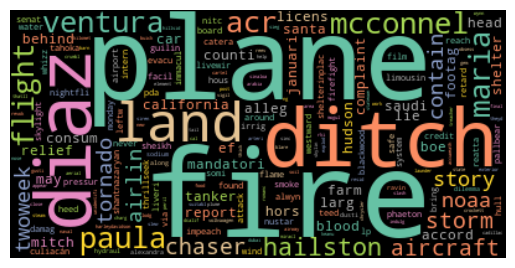

In [19]:
# skorzystajmy ze znanej juz biblioteki, by to lepiej zwizualizowac
def plot_vector(tf_idf_vector):
    wordcloud = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud.generate_from_frequencies(frequencies=tf_idf_vector)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

plot_vector(user_vectors[test_users[0]])

## Część 5. - Rekomendacje dla użytkowników

User: U53231
History (28):
id: N58936
	title: Beloved grandfather's body pulled from collapsed Hard Rock hotel
	text: A family holding vigil outside the site of the Hard Rock hotel construction collapse received the news they hoped they'd never hear.
id: N15919
	title: Saddleridge fire calms down, heavy rains on East Coast
	text: A new storm system is developing in the southern Plains and will move east over the next few days bringing a threat of flooding to the South with rain and gusty winds.
id: N11917
	title: JetBlue Plane Makes Emergency Landing at JFK Airport
	text: The plane landed safely in NYC Sunday night.
id: N2153
	title: Iran alleges foreign government behind 'treacherous' ship attack
	text: Iran said Monday a foreign government was behind what it alleges was a "treacherous" attack on a tanker off Saudi Arabia last week, as it released pictures of its damaged hull. But the state-owned NITC denied reports the alleged attack had originated from Saudi soil.
id: N55312
	title:

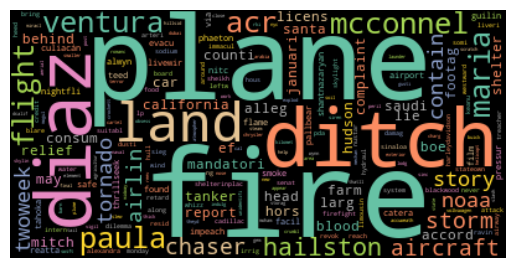


Recommendations top-5:
id: N58169
	title: Helicopter crews take on California's Maria fire with nighttime flights
	text: Ventura County Fire crews battling the Maria Fire in California used nighttime helicopter flights to control the blaze, according to local authorities. "Helicopters that fight fire at night are not common. They take special knowledge, skills, training and technology," Ventura County Fire wrote on Twitter. The Maria Fire broke out in the hills above Santa Paula and began to spread on Thursday evening, October 31. By the evening of November 3, authorities said, the fire has grown to 9,412 acres but was 70 percent contained. Only two structures were destroyed by the fire, but widespread evacuation orders were in place. The Ventura County Sheriff said that 1,800 structures were threatened as the fire grew on October 31 and that 7,500 people were under evacuation orders. Credit: Ventura County Fire via Storyful
id: N58561
	title: Wildfire Alert Cameras Captures Ignition 

In [20]:
# wykorzystujac wektory tresci i profile uzytkownikow,
#   wygeneruj liste k artykulow najlepiej dopasowanych do uzytkownika
#   pamietaj o odsianiu artykulow, ktore uzytkownik juz kliknal

def recommend(tf_idf, user_id, news, users_history, k, metric="cosine"):
    history = users_history.get(user_id, [])
    clicked = set(history)

    user_vec = calculate_average_vector(tf_idf, [nid for nid in clicked])

    local = dict(tf_idf)
    tmp_id = "user_id"
    local[tmp_id] = user_vec

    pairs = (
        (calculate_distance(local, tmp_id, nid, metric), nid)
        for nid in tf_idf.keys()
        if nid not in clicked
    )

    ranked = sorted(pairs, key=lambda x: x[0])
    k = min(k, len(ranked))

    return [nid for _, nid in ranked[:k]]

# dla wybranego uzytkownika, korzystajac z juz zaimplementowanych funkcji,
#   pokaz jego historie, profil (wordcloud) i rekomendacje

def show_user_history_profile_and_recs(tf_idf, user_id, news, users_history, k=10):
    history = users_history.get(user_id, [])
    print(f"User: {user_id}\nHistory ({len(history)}):")
    for nid in history:
        print_news_entry(nid, news)

    user_vec = calculate_average_vector(tf_idf, list(set(history)))
    plot_vector(user_vec)

    recs = recommend(tf_idf, user_id, news, users_history, k)
    print(f"\nRecommendations top-{k}:")
    for nid in recs:
        print_news_entry(nid, news)


show_user_history_profile_and_recs(tf_idf, test_users[0], news, users_history, k=5)

## Część 6. - Ocena jakości

In [21]:
# jaccard index to metryka podobienstwa zbiorow, lekko ja zmodyfikujemy
# przeciecie wektorow to minimum po kazdej wspolrzednej
# unia wektorow to maksimum po kazdej wspolrzednej
# jaccard index to iloraz sum tych dwoch wartosci

def jaccard(v1, v2):
    if not v1 or not v2:
        return 0

    inter = 0
    for k, w in v1.items():
        b = v2.get(k)
        if b is not None:
            inter += w if w < b else b

    sum1 = sum(v1.values())
    sum2 = sum(v2.values())
    union = sum1 + sum2 - inter

    if union <= 0:
        return 0
    
    return inter / union

In [22]:
# dla kazdego uzytkownika wygeneruj k-elementowa rekomendacje
# policz jaccard index miedzy wektorem uzytkownika a srednim wektorem elementow z rekomendacji
# porownaj wyniki dla dwoch roznych k i dwoch roznych metryk podobienstwa

def recommend_by_metric(tf_idf, user_id, users_history, k, metric, candidate_ids):
    hist = users_history.get(user_id, [])
    clicked = {nid for nid in hist if nid in tf_idf}
    user_vec = calculate_average_vector(tf_idf, list(clicked))

    local = dict(tf_idf)
    tmp_id = "user_id"
    local[tmp_id] = user_vec

    sims = []
    if metric == "cosine":
        for nid in candidate_ids:
            if nid in clicked:
                continue
            d = calculate_distance(local, tmp_id, nid, "cosine")
            sims.append((1 - d, nid))
    elif metric == "jaccard":
        for nid in candidate_ids:
            if nid in clicked:
                continue
            vec = tf_idf.get(nid)
            sims.append((jaccard(user_vec, vec), nid))

    sims.sort(key=lambda x: x[0], reverse=True)
    k = max(0, min(k, len(sims)))
    return [nid for _, nid in sims[:k]]

def evaluate_jaccard_between_user_and_recs(
    tf_idf,
    users_history,
    k_values,
    metrics,
    users,
):
    candidate_ids = list(tf_idf.keys())
    results = { (m, k): [] for m in metrics for k in k_values }
    for uid in users:
        hist = users_history.get(uid, [])
        user_vec = calculate_average_vector(tf_idf, list({nid for nid in hist if nid in tf_idf}))

        for m in metrics:
            for k in k_values:
                recs = recommend_by_metric(tf_idf, uid, users_history, k, metric=m, candidate_ids=candidate_ids)
                rec_centroid = calculate_average_vector(tf_idf, recs)
                results[(m, k)].append(jaccard(user_vec, rec_centroid))

    for (m, k), arr in results.items():
        if arr:
            avg = sum(arr) / len(arr)
            print(f"Metric={m} \tk={k} \tmean Jaccard(user, recs) = {avg}")

    return results

In [23]:
results = evaluate_jaccard_between_user_and_recs(
    tf_idf,
    users_history,
    k_values=(5, 10),
    metrics=("cosine", "jaccard"),
    users=list(test_users),
)

Metric=cosine 	k=5 	mean Jaccard(user, recs) = 0.046326757918147915
Metric=cosine 	k=10 	mean Jaccard(user, recs) = 0.060679805903989914
Metric=jaccard 	k=5 	mean Jaccard(user, recs) = 0.049793145390788454
Metric=jaccard 	k=10 	mean Jaccard(user, recs) = 0.07426898377906606
